In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from os.path import exists
import time
import torch.nn.functional as F
import math
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms




In [128]:
def Sign(x):
  if x>=0:
    return 1
  else:
    return -1

def plot_multiple_samples(data,x_dim):

    length = data.shape[0]
    y_dim = math.floor(length/x_dim)
    fig, axes = plt.subplots(nrows = x_dim, ncols = y_dim, figsize = (8,8))#, sharex=True, sharey=True)
    for i in range(x_dim):
      for j in range(y_dim):
        axes[i,j].imshow(data[j + i*y_dim,:,:,:].permute(1,2,0)/255)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        
    fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()

def plot_samples_and_rating(data,ratings,x_dim):

    length = data.shape[0]
    y_dim = math.floor(length/x_dim)
    fig, axes = plt.subplots(nrows = x_dim, ncols = y_dim, figsize = (10,10))#, sharex=True, sharey=True)
    for i in range(x_dim):
      for j in range(y_dim):
        axes[i,j].imshow(data[j + i*y_dim,:,:,:].permute(1,2,0)/255)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title("{:.2f}".format(ratings[j + i*y_dim].item()))

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    #plt.subplots_adjust(left=0, right=1, top=1, bottom=0) 

    plt.show()

def plot_prediction_and_truth(data,ratings,predictions,x_dim,UseSign):

    length = data.shape[0]
    y_dim = math.floor(length/x_dim)
    fig, axes = plt.subplots(nrows = x_dim, ncols = y_dim, figsize = (10,10))#, sharex=True, sharey=True)
    for i in range(x_dim):
      for j in range(y_dim):
        axes[i,j].imshow(data[j + i*y_dim,:,:,:].permute(1,2,0)/255)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        if(UseSign):
          title = "tr {truth:.0f} pr {prediction:.0f}".format(truth = ratings[j + i*y_dim], prediction = predictions[j+i*y_dim])
          if(ratings[j + i*y_dim] == predictions[j+i*y_dim]):
            axes[i,j].set_title(title, color = 'g')
          else:
            axes[i,j].set_title(title, color = 'r')

        else:   
          title = "tr {truth:.2f} - pr {prediction:.2f}".format(truth = ratings[j + i*y_dim].item(), prediction = predictions[j+i*y_dim])
          axes[i,j].set_title(title)

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    #plt.subplots_adjust(left=0, right=1, top=1, bottom=0) 

    plt.show()

In [ ]:
##### Loads the data ####
data_file = "/content/drive/MyDrive/Colab Notebooks/books/data.csv"
image_path = "/content/drive/MyDrive/Colab Notebooks/books/scaled_images/"

data_full = pd.read_csv(data_file)
image_files = os.listdir(image_path)
#   img = Image.open(image_path + image_files[ID]) gets 
# data_full['average_rating'][data_full.loc[data_full['ID_number'] == int(image_files[ID][:-4])].index.values[0]] # to get a given 

n = len(image_files)
images = torch.empty(n,3,224,224)
ratings = torch.empty(n,1)
transform = transforms.Compose([transforms.PILToTensor()])

for i in range(n):
  img = Image.open(image_path + image_files[i])
  if img.mode == 'RGBA':
    img = img.convert('RGB')

  img_tensor = transform(img)
  #print(img_tensor.shape)
  #print(img.mode)
  images[i,0:3,:,:] = img_tensor #selecting RGB channels only if image is rgba
  ratings[i,:] = data_full['average_rating'][data_full.loc[data_full['ID_number'] == int(image_files[i][:-4])].index.values[0]]


### Normalise the ratings data to have mean 0 and std of 1:
ratings_mean = ratings.mean()
ratings_std = ratings.std()

print('Initial: mean = {mean:.2f}, std = {std:.2f}'.format(mean = ratings.mean(),std = ratings.std()))

for i in range(n):
  ratings[i,:] = (ratings[i,:]-ratings_mean)/ratings_std

print('New: mean = {mean:.2f}, std = {std:.2f}'.format(mean = ratings.mean(),std = ratings.std()))


Initial: mean = 3.78, std = 0.74
New: mean = 0.00, std = 1.00


In [63]:
###### Set up dataloaders ############
#images
#ratings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TensorDataset(images.to(device),ratings.to(device))
train_set, val_set = torch.utils.data.random_split(dataset, [2500, 620])

bs = 16
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_set, batch_size=bs, shuffle=True)




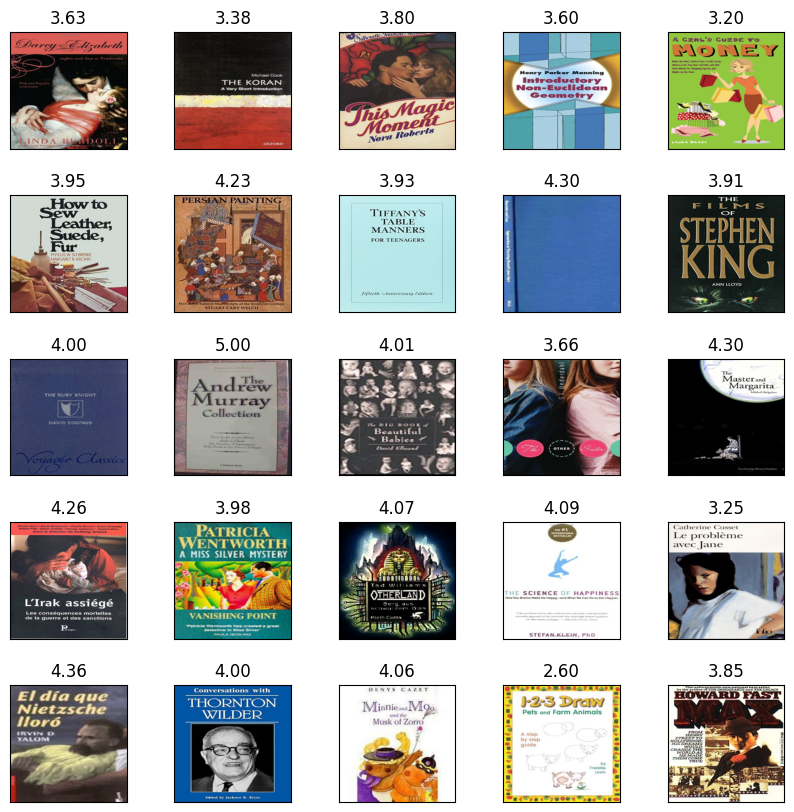

In [ ]:
#### This cell prints grids of images and matching ratings to confirm the data has loaded correctly and to display a sample ######

n = 25
image_subset = torch.empty((n,3,224,224))
ratings_subset = torch.empty(n,1)

transform = transforms.Compose([transforms.PILToTensor()])
for i in range(n):
  ID = random.randint(0, len(image_files))
  img = Image.open(image_path + image_files[ID])
  img_tensor = transform(img)
  image_subset[i,:,:,:] = img_tensor

  #image_subset.append(img_tensor)

  ratings_subset[i] = data_full['average_rating'][data_full.loc[data_full['ID_number'] == int(image_files[ID][:-4])].index.values[0]]
  #print(data_full['average_rating'][data_full.loc[data_full['ID_number'] == int(image_files[ID][:-4])].index.values[0]])
  #print(data_full['title'][data_full.loc[data_full['ID_number'] == int(image_files[ID][:-4])].index.values[0]])

#print(ratings_subset)

#plot_multiple_samples(image_subset,5)
plot_samples_and_rating(image_subset,ratings_subset,5)

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/

# This block imports the VGG16 pretrained classifier

import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)

# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

# Then add a classifier layer to the end to give a single value as an output
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 outputs (the predicted rating!)
model.classifier = nn.Sequential(*features) # Replace the model classifier
print(model)
model.to(device)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
####### Model evaluation ########

def average_abs_value(nums):
    total = 0
    count = 0
    for num in nums:
        total += abs(num.item())  # Add the absolute value
        count += 1
    return total / count


def Evaluate_Model(model, data):

  values = []
  errors = []
  for x, y in data:
    # Get model output
    with torch.no_grad():
      #print('prediction: {predicted}, reality: {truth}'.format(predicted = model(x)[0].item(), truth = y[0].item()))
      predicted = model(x)
      for i in range(len(predicted)):
        values.append((predicted[i],y[i]))
        errors.append(y[i] - predicted[i])
        #print(y[i] - predicted[i])
  average_error = average_abs_value(errors)
  print('The average absolute error is {avg:.2f}'.format(avg = average_error))
  return(average_error)

Evaluate_Model(model, train_loader)

The average absolute error is 5.86


5.857521137565374

In [ ]:
def load_model(model,optimiser,modelPath):

  if exists(modelPath):
    checkpoint = torch.load(modelPath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
    iterNumber = checkpoint['batch']
    loss = checkpoint['loss']
    print('Loaded model at ' + modelPath)
  else:
    print('No file found')

  return model,optimiser,iterNumber

In [ ]:
############# Backprop #############

def run_backpropogation_optimisation(device,model,data,epochs,criterion,optimiser,lr_scheduler,losses,iterNumber,lr):
    start = time.time()
    #model.to(device)
    for epoch in range(epochs):
      epochStart = time.time()
      batch_number = 0
      for x, y in data:
        
        batch_time = time.time()
        batch_number += 1
        iterNumber += 1

        x.to(device)
        y.to(device)
        optimiser.zero_grad()
        yPrediction = model(x)
        loss = criterion(yPrediction, y)
        loss.backward()
        optimiser.step()
        losses.append(loss.item())
        if batch_number % 20 ==0:
          print('Batch number {batch} loss: {loss:.2f} in {time:.1f}s'.format(batch = batch_number,loss = loss.item(),time = time.time() - batch_time))

        #if i % 20 == 0:
          # This is optional to see how decreasing error feeds into correct classification
         # percentCorrect.append([n,run_test_set(model,testFiles,plotNumberIncorrectSubset,nTest,device,False)])

      end = time.time()

      print('Epoch [' + str(epoch+1) + '/' + str(epochs) + '] training time: ' + str(round(end - start,2)) + 
            's at a learning rate of ' + str(lr) + ' with a final loss of ' + str(round(loss.item(),3)))
    return model, losses, optimiser, iterNumber

In [68]:
#train_set, val_set
#train_loader, val_loader

import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model.to(device)
lr=0.0001
criterion = nn.MSELoss()
optimizer_ft = optim.Adam(model.parameters(), lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

losses = []
iterNumber = 0

Using cuda device


In [69]:
loadModel = False
saveModel = True
fileFolder = '/content/drive/MyDrive/Colab Notebooks/books'

modelPath = fileFolder+'/book_cover_rater.pt'


if loadModel:
  model,optimiser_ft,iterNumber = load_model(model,optimizer_ft,modelPath)

n_batch = 1
model,losses,optimiser_ft,iterNumber = run_backpropogation_optimisation(device,model,train_loader,n_batch,criterion,
                                                                        optimizer_ft,exp_lr_scheduler,losses,iterNumber,lr)

print('Final loss value of: ' + str(round(losses[-1],3)))


if saveModel:
    torch.save({
        'batch': iterNumber,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser_ft.state_dict(),
        'loss': losses[-1],
            }, modelPath)
    print('Model saved as "' + modelPath + '"')



Batch number 20 loss: 0.53 in 0.3s
Batch number 40 loss: 2.04 in 0.3s
Batch number 60 loss: 0.13 in 0.3s
Batch number 80 loss: 5.10 in 0.3s
Batch number 100 loss: 0.31 in 0.3s
Batch number 120 loss: 3.44 in 0.3s
Batch number 140 loss: 1.99 in 0.3s
Epoch [1/1] training time: 40.23s at a learning rate of 0.0001 with a final loss of 0.325
Final loss value of: 0.325
Model saved as "/content/drive/MyDrive/Colab Notebooks/train_classifier/book_cover_rater.pt"


In [70]:
Evaluate_Model(model,val_loader)


The average absolute error is 0.58


0.5773109254690127

157


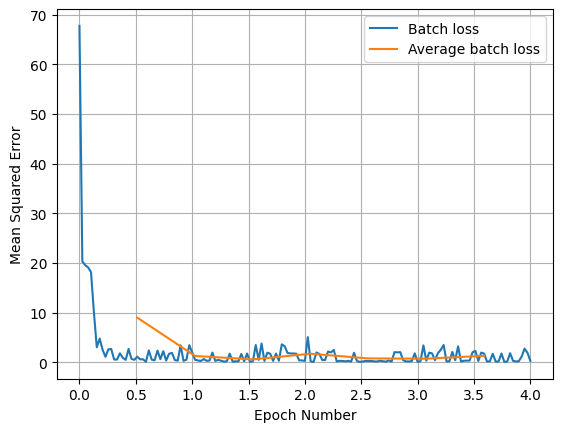

In [71]:
#plt.plot([math.log(x) for x in losses])
print(len(losses))
n = 20
average_loss = []
loss_number = []

sum = 0
for i in range(len(losses)):
  x = losses[i]
  if i % n == 0:
    loss_number.append(i/39)
    average_loss.append(sum/n)
    sum = 0
  sum += x
#plt.plot(average_loss)

plt.figure()
plt.grid()
plt.plot([x/39 for x in range(len(losses))],losses,label = 'Batch loss')
plt.plot(loss_number[1:],average_loss[1:], label = 'Average batch loss')
#plt.ylim([0,5])
plt.xlabel('Epoch Number')
plt.ylabel('Mean Squared Error')
plt.legend()


#2500 train - 156 batches per epoch
#620 test

In [137]:
#### Find structure of predictions ####
import statistics as st
import numpy as np

def Model_Distribution(model, data):

  values = []
  errors = []
  truth = []
  for x, y in data:
    # Get model output
    with torch.no_grad():
      #print('prediction: {predicted}, reality: {truth}'.format(predicted = model(x)[0].item(), truth = y[0].item()))
      predicted = model(x)
      for i in range(len(predicted)):
        values.append(predicted[i].item())
        errors.append((y[i] - predicted[i]).item())
        truth.append(y[i].item())

  mean_e = st.mean(errors)
  std_e = np.array(errors).std()
  mean_v = st.mean(values)
  std_v = np.array(values).std()

  return mean_e, std_e, mean_v, std_v, errors, values, truth

mean_e, std_e, mean_v, std_v, errors, values, truth = Model_Distribution(model, val_loader)

#ratings_mean = ratings.mean()
#ratings_std = ratings.std()

#errors = [x*ratings_std for x in errors]
#values = [x*ratings_std + ratings_mean for x in values]

print('Errors have {em:.3f} mean and {es:.3f} std.'.format(em = mean_e, es = std_e))
print('Predicted values have {em:.3f} mean and {es:.3f} std.'.format(em = mean_v, es = std_v))


Errors have 0.127 mean and 0.995 std.
Predicted values have -0.094 mean and 0.164 std.


In [ ]:
plt.figure()
plt.grid()
plt.hist(values, bins=30)
plt.xlabel('Predicted Values')
plt.figure()
plt.grid()
plt.hist(errors, bins=30)
plt.xlabel('Prediction Errors')

In [139]:
########### See if the classifier is good at predicting above or below average ##########
def Sign(x):
  if x>=0:
    return 1
  else:
    return -1
def Sign_List(x):
  return [Sign(a) for a in x]

num_correct = 0
num_incorrect = 0
values_sign = Sign_List(values)
truth_sign = Sign_List(truth)
for i in range(len(values)):
  if values_sign[i] == truth_sign[i]:
    num_correct += 1
  else:
    num_incorrect += 1

print('[{correct}/{total}]'.format(correct = num_correct, total = num_correct + num_incorrect))
print('This is {percentage:.1f}%'.format(percentage = 100*num_correct/(num_correct + num_incorrect)))

num_high = 0
num_low = 0
for x in values:
  if x>=0:
    num_high += 1
  else:
    num_low += 1

print(num_high, num_low)


[252/620]
This is 40.6%
180 440


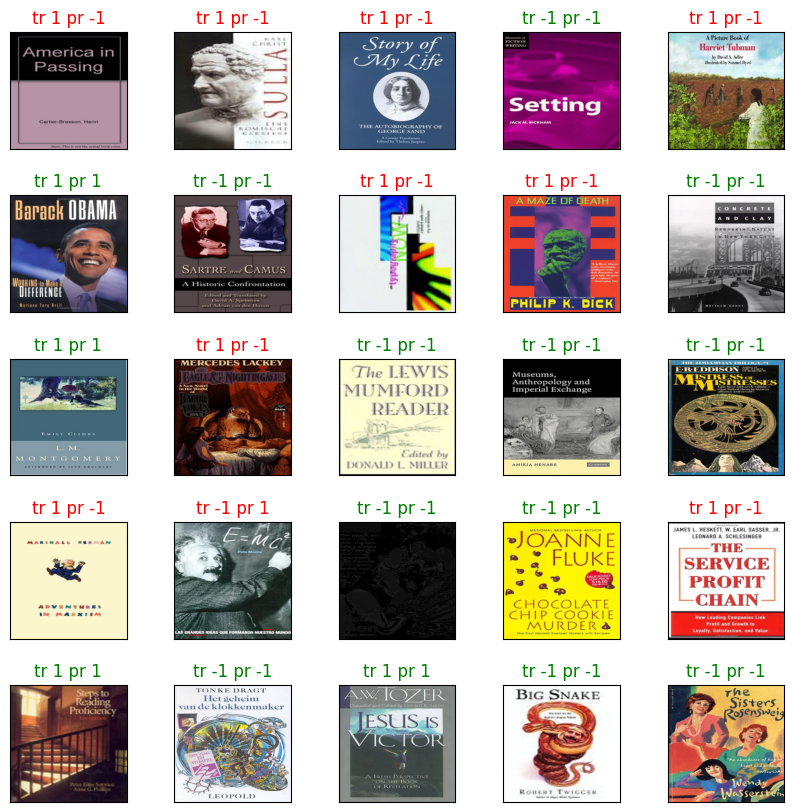

In [133]:
############ print predictions and truth ##############


#ratings_mean = ratings.mean()
#ratings_std = ratings.std()

def prediction_sample(UseSign):
  n = 25
  image_subset = torch.empty((n,3,224,224))
  ratings_subset = torch.empty(n,1)

  transform = transforms.Compose([transforms.PILToTensor()])
  for i in range(n):
    ID = random.randint(0, len(image_files))
    img = Image.open(image_path + image_files[ID])
    if img.mode == 'RGBA':
      img = img.convert('RGB')
    img_tensor = transform(img)
    image_subset[i,:,:,:] = img_tensor
    #image_subset.append(img_tensor)
    #print(img_tensor.shape)

    ratings_subset[i] = data_full['average_rating'][data_full.loc[data_full['ID_number'] == int(image_files[ID][:-4])].index.values[0]]
  with torch.no_grad():
    predictions = model(image_subset.to(device))
  predictions = predictions.tolist()
  ls = []
  if(UseSign):
    ratings_subset = [Sign(x - ratings_mean) for x in ratings_subset]
    for x in predictions:
      ls.append(Sign(x[0]))
  else:
    for x in predictions:
      ls.append(x[0]*ratings_std + ratings_mean)


  plot_prediction_and_truth(image_subset,ratings_subset,ls,5,UseSign)

prediction_sample(True)
 